In [1]:
%reset

import sys
sys.path.append("../") 

import healpy as hp
import numpy as np
from astropy.io import fits
from astropy import wcs
from scipy import interpolate
import pickle as pk

import FermiBackgrounds


import pdb

import matplotlib.pyplot as pl

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [2]:
energy_range = [1000, 100000] #this is in MeV

In [3]:
bg_file = '../data/FermiData/gll_iem_v07.fits'

bg_data = fits.open(bg_file)
w = wcs.WCS(bg_data[0].header)

dims = bg_data[0].shape
print("dims = ", dims)
N_energy = dims[0]
N_side = 64
N_pix = 12*N_side**2

map_all = np.zeros((N_energy, N_pix))

for ri in range(0,dims[1]):
    if (ri % 100 == 0):
        print("ri = ", ri)
    cols = np.arange(0,dims[2])
    coord = w.pixel_to_world(cols, ri,0)
    l, b = coord[0].l.deg, coord[0].b.deg
    good = np.where(np.isfinite(l))
    vals_good = bg_data[0].data[:,ri,good]
    pix_indices = hp.ang2pix(N_side, l[good], b[good], lonlat = True)
    unique_pix = np.unique(pix_indices)
    for ui in range(0,len(unique_pix)):
        match = np.where(pix_indices == unique_pix[ui])[0]
        #average over all pixels falling into this healpix pixel        
        map_all[:,unique_pix[ui]] = np.mean((vals_good[:,0,:])[:,match], axis = 1)

dims =  (28, 1441, 2880)
ri =  0
ri =  100
ri =  200
ri =  300
ri =  400
ri =  500
ri =  600
ri =  700
ri =  800
ri =  900
ri =  1000
ri =  1100
ri =  1200
ri =  1300
ri =  1400


In [4]:
save_file = False
if (save_file):
    to_save = {'galactic_bg':map_all, 'energies_MeV':np.copy(bg_data[1].data['energy'])}
    pk.dump(to_save, open('../data/FermiData/galactic_bg_healpix_Nside' + str(N_side) + '.pk','wb'))

In [5]:
#sum over energies

E_cents = bg_data[1].data['energy']
print(E_cents)

E_fine = np.exp(np.linspace(np.log(energy_range[0]), np.log(energy_range[1]), num = 200))
dE_fine = E_fine[1:] - E_fine[:-1]

gal_bg_map = np.zeros(N_pix)
for ii in range(0,N_pix):
    if (ii % 10000 == 0):
        print(ii)
    ff = interpolate.interp1d(E_cents, map_all[:,ii])
    to_integrate = ff(E_fine)
    gal_bg_map[ii] = np.sum(0.5*dE_fine*(to_integrate[1:] + to_integrate[:-1]))

[5.00000000e+01 6.49828300e+01 8.44553639e+01 1.09762971e+02
 1.42654170e+02 1.85401433e+02 2.40958196e+02 3.13162910e+02
 4.07004243e+02 5.28965751e+02 6.87473830e+02 8.93479900e+02
 1.16121705e+03 1.50918340e+03 1.96142017e+03 2.54917267e+03
 3.31304908e+03 4.30582611e+03 7.27300221e+03 1.22848810e+04
 2.07504819e+04 3.50497899e+04 5.92028552e+04 9.99999737e+04
 1.68910683e+05 2.85308264e+05 4.81916266e+05 8.14008272e+05]
0
10000
20000
30000
40000


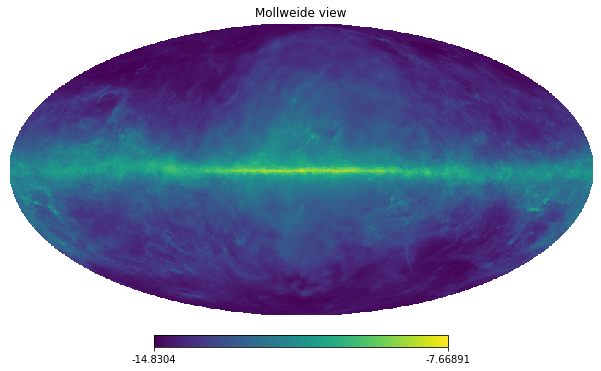

In [6]:
hp.mollview(np.log(gal_bg_map))

In [8]:
#Isotropic background

# Energy spectrum setup
#We use FermiBackgrounds to get the background spectrum and mean flux
fermi_data_path = '../data/FermiData/'
background_generator = FermiBackgrounds.FermiBackgrounds(fermi_data_path)
fermi_iso = background_generator.get_isotropic_background_spectrum_func()
#mean_iso_bg_flux has units of 1./cm^2/s/sr
mean_iso_bg_flux = background_generator.get_mean_isotropic_flux(energy_range[0], energy_range[1])
print(mean_iso_bg_flux)

5.003264446734353e-07


mean flux / iso =  2.7381983468850457
fraction unmasked =  0.4249674479166667
fraction unmasked 2 =  0.4119059244791667


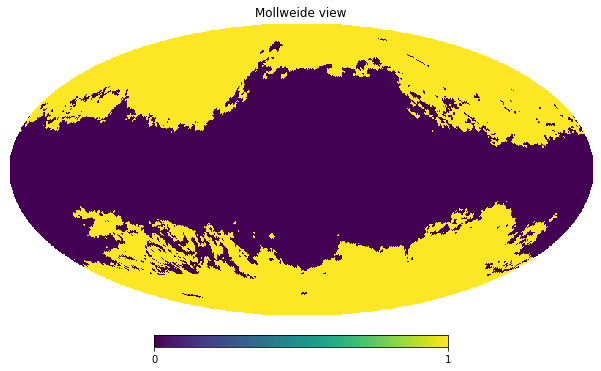

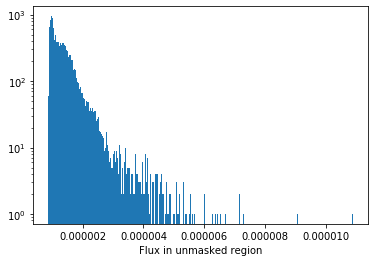

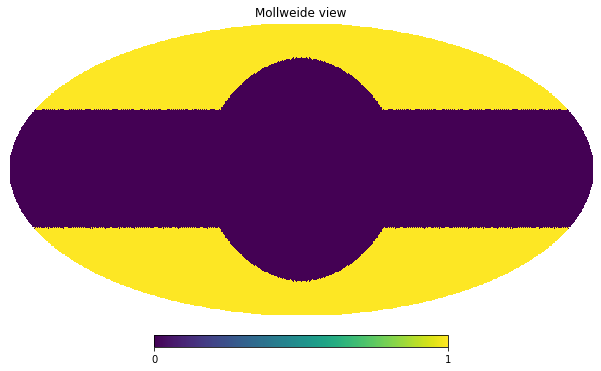

In [11]:
mask = np.zeros(len(gal_bg_map))
total_model = gal_bg_map + mean_iso_bg_flux
good = np.where(total_model < 2.0*np.min(total_model))
mask[good] = 1.0
hp.mollview(mask)


#simple mask
gal_lat_cut = 30
lon, lat = hp.pix2ang(N_side, np.arange(N_pix), lonlat = True)
mask2 = np.zeros(len(gal_bg_map))
good = np.where(np.abs(lat) > 30.)[0]
mask2[good] = 1.0

def hav(theta):
    return np.sin(theta/2.)**2.

def ang_sep(lon1, lat1, lon2, lat2):
    #Haversine formula
    theta = 2.*np.arcsin(np.sqrt(hav(lat1 - lat2) + np.cos(lat1)*np.cos(lat2)*hav(lon1-lon2)))
    return theta

angle_to_galcenter = (180./np.pi)*ang_sep(0., 0., lon*np.pi/180., lat*np.pi/180.)
near_center = np.where(angle_to_galcenter < 60.)[0]
mask2[near_center] = 0.

in_mask = np.where(mask2 == 1)[0]
fig, ax = pl.subplots(1,1)
ax.hist(total_model[in_mask], bins = 500)
ax.set_yscale('log')
ax.set_xlabel('Flux in unmasked region')


hp.mollview(mask2)

print("mean flux / iso = ", np.mean(total_model[in_mask])/mean_iso_bg_flux)

print("fraction unmasked = ", np.sum(mask)/len(mask))
print("fraction unmasked 2 = ", np.sum(mask2)/len(mask2))

In [12]:
print(np.mean(total_model[in_mask]))


test =  background_generator.get_masked_isotropic_flux('../data/FermiData/galactic_bg_healpix_Nside64.pk',\
                                                      30., 60., energy_range[0], energy_range[1])
print("test = ", test)

1.369993043707673e-06
test =  1.369993043707673e-06


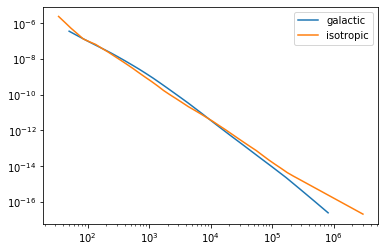

In [15]:
#compare spectrum of isotropic and galactic background models

ee, dnde = background_generator.get_isotropic_background_spectrum()

fig, ax = pl.subplots(1,1)
ax.plot(E_cents, np.mean(map_all[:,in_mask],axis=1), label = 'galactic')
ax.plot(ee, dnde, label = 'isotropic')

ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')

In [39]:
print(bg_data[0].header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 2880                                                  NAXIS2  =                 1441                                                  NAXIS3  =                   28                                                  EXTEND  =                    T                                                  CRVAL1  =                    0                                                  CDELT1  =               -0.125                                                  CRPIX1  =               1440.5                                                  CTYPE1  = 'GLON-CAR'                                                            CUNIT1  = 'deg     '                                                            CRVAL2  =                    0          

In [ ]:
fig, ax = pl.subplots(1,1)
ax.imshow(np.log(bg_data[0].data[0,:,:]))

hp.mollview(np.log(map_all[0,:]))